In [ ]:
pip install pydicom


In [ ]:
pip install nibabel

In [ ]:


hip_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Images"
hip_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Annotations"
knee_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

Number of DICOM images: 773
Number of annotation files: 773


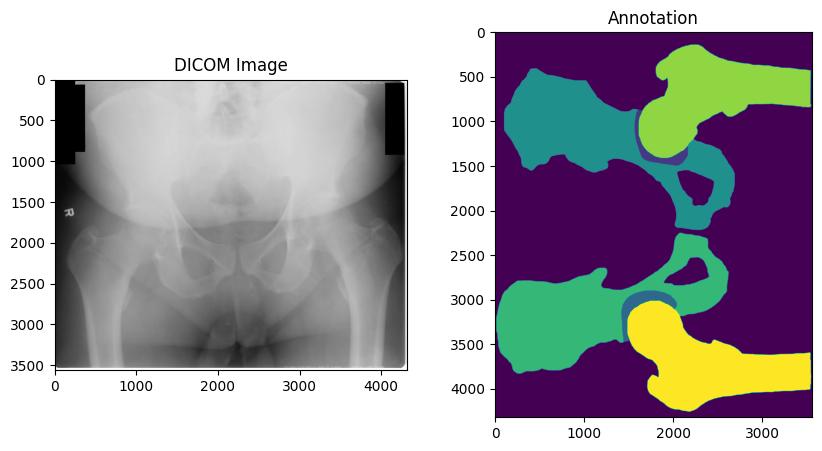

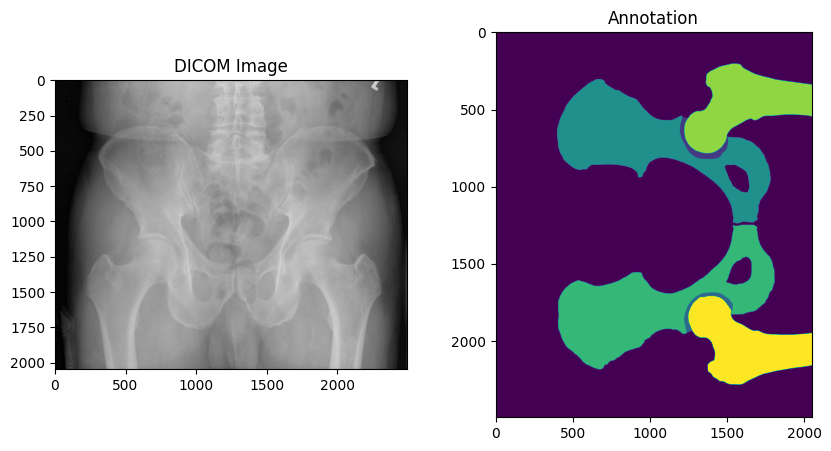

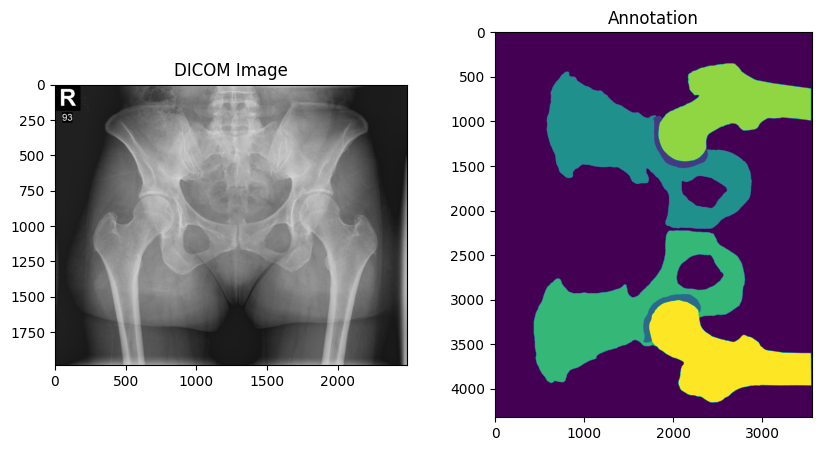

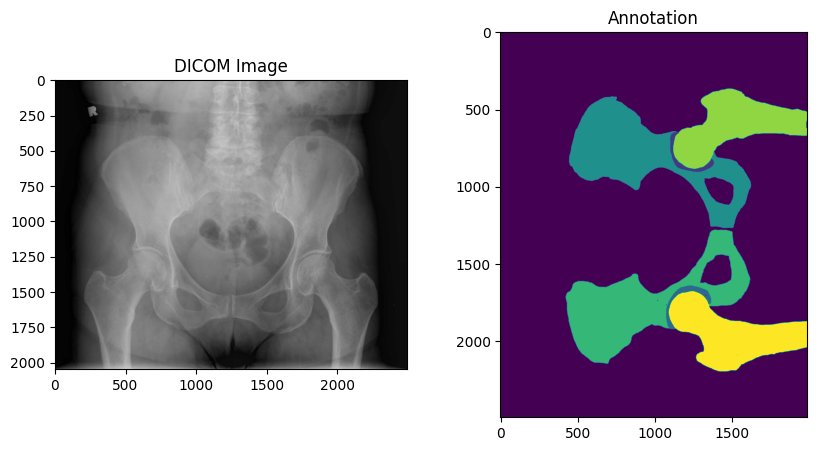

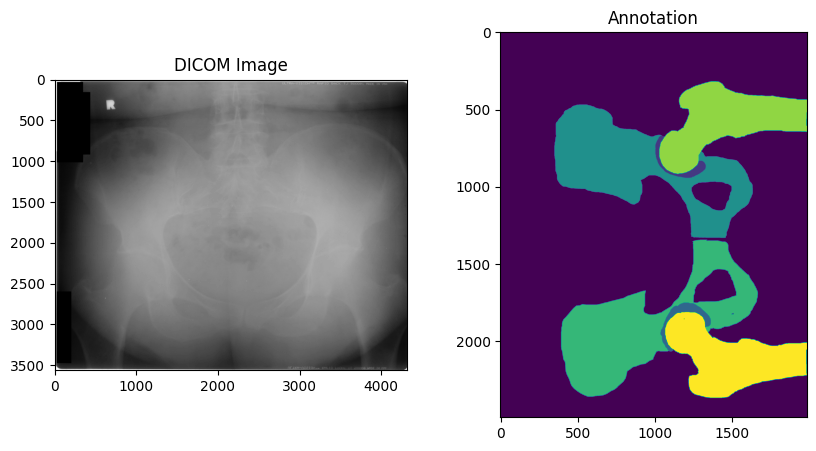

In [ ]:
import os
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt

def load_and_visualize_data(images_folder, annotations_folder):
    # Load DICOM images
    image_files = [file for file in os.listdir(images_folder) if file.endswith(".dcm")]
    annotation_files = [file for file in os.listdir(annotations_folder) if file.endswith(".nii.gz")]

    # Display the number of images and annotations
    print(f"Number of DICOM images: {len(image_files)}")
    print(f"Number of annotation files: {len(annotation_files)}")

    # Visualize a few samples
    for i in range(min(5, len(image_files))):
        image_path = os.path.join(images_folder, image_files[i])
        annotation_path = os.path.join(annotations_folder, annotation_files[i])

        # Load DICOM image
        dicom_image = pydicom.dcmread(image_path)
        image_array = dicom_image.pixel_array

        # Load annotation
        annotation = nib.load(annotation_path).get_fdata()

        # Plot the image and annotation side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image_array, cmap='gray')
        plt.title("DICOM Image")

        plt.subplot(1, 2, 2)
        plt.imshow(annotation, cmap='viridis')
        plt.title("Annotation")

        plt.show()

# Explore hip dataset
load_and_visualize_data(hip_images_folder, hip_annotations_folder)


Skipping 9025191.dcm and 9025191.nii.gz due to inconsistent shapes: (128, 128, 1), (128, 128, 2)
Epoch 1/30
3/3 [==============================] - 8s 1s/step - loss: 0.6931 - accuracy: 0.4144 - val_loss: 0.6929 - val_accuracy: 0.5536
Epoch 2/30
3/3 [==============================] - 2s 659ms/step - loss: 0.6927 - accuracy: 0.6146 - val_loss: 0.6925 - val_accuracy: 0.5536
Epoch 3/30
3/3 [==============================] - 2s 653ms/step - loss: 0.6924 - accuracy: 0.6146 - val_loss: 0.6921 - val_accuracy: 0.5536
Epoch 4/30
3/3 [==============================] - 2s 661ms/step - loss: 0.6920 - accuracy: 0.6146 - val_loss: 0.6917 - val_accuracy: 0.5536
Epoch 5/30
3/3 [==============================] - 2s 596ms/step - loss: 0.6916 - accuracy: 0.6146 - val_loss: 0.6914 - val_accuracy: 0.5536
Epoch 6/30
3/3 [==============================] - 2s 584ms/step - loss: 0.6912 - accuracy: 0.6146 - val_loss: 0.6910 - val_accuracy: 0.5536
Epoch 7/30
3/3 [==============================] - 2s 663ms/step - 

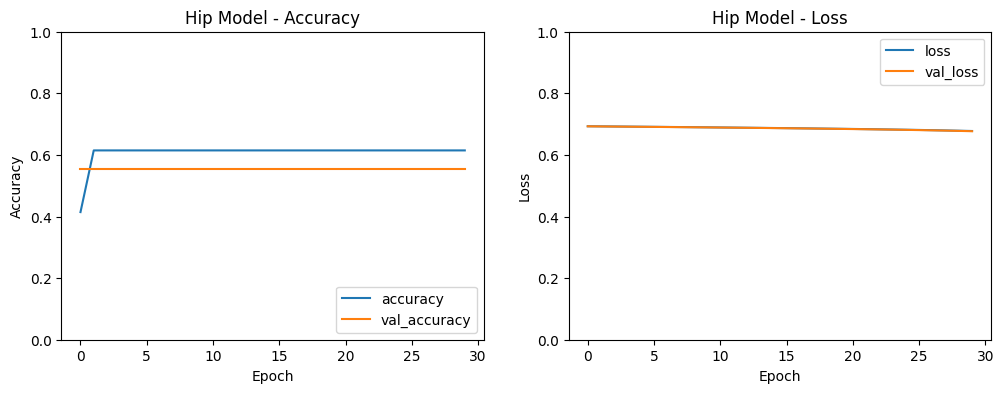

Epoch 1/30
3/3 [==============================] - 8s 881ms/step - loss: 0.6929 - accuracy: 0.6078 - val_loss: 0.6923 - val_accuracy: 0.6655
Epoch 2/30
3/3 [==============================] - 2s 621ms/step - loss: 0.6921 - accuracy: 0.6325 - val_loss: 0.6914 - val_accuracy: 0.6655
Epoch 3/30
3/3 [==============================] - 2s 672ms/step - loss: 0.6912 - accuracy: 0.6325 - val_loss: 0.6905 - val_accuracy: 0.6655
Epoch 4/30
3/3 [==============================] - 2s 612ms/step - loss: 0.6903 - accuracy: 0.6325 - val_loss: 0.6895 - val_accuracy: 0.6655
Epoch 5/30
3/3 [==============================] - 2s 662ms/step - loss: 0.6894 - accuracy: 0.6325 - val_loss: 0.6885 - val_accuracy: 0.6655
Epoch 6/30
3/3 [==============================] - 3s 1s/step - loss: 0.6884 - accuracy: 0.6325 - val_loss: 0.6874 - val_accuracy: 0.6655
Epoch 7/30
3/3 [==============================] - 3s 814ms/step - loss: 0.6873 - accuracy: 0.6325 - val_loss: 0.6863 - val_accuracy: 0.6655
Epoch 8/30
3/3 [=======

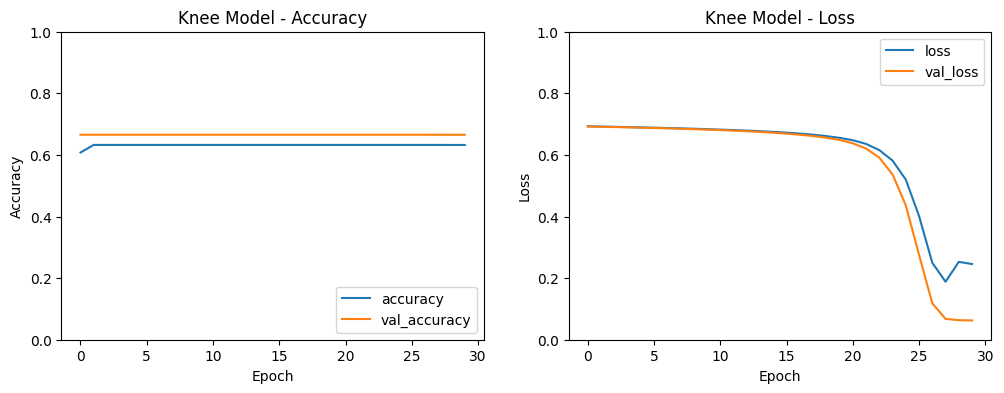

In [ ]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set the paths
hip_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Images"
hip_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Annotations"
knee_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Parameters
img_height, img_width = 128, 128
num_samples = 50  # Adjusted for 10,20,50,100,200,400,600
def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    image = apply_voi_lut(dicom.pixel_array, dicom)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image
    image = image - np.min(image)
    if np.max(image) != 0:
        image = image / np.max(image)
    return image
def load_data(images_folder, annotations_folder, num_samples):
    images = []
    masks = []

    image_files = sorted(os.listdir(images_folder))[:num_samples]
    annotation_files = sorted(os.listdir(annotations_folder))[:num_samples]

    for img_file, ann_file in zip(image_files, annotation_files):
        img_path = os.path.join(images_folder, img_file)
        img = load_dicom_image(img_path)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        img = np.expand_dims(img, axis=-1)  # Ensure the image is 3D with shape (height, width, channels)

        ann_path = os.path.join(annotations_folder, ann_file)
        ann_img = nib.load(ann_path).get_fdata()
        ann_img = resize(ann_img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        if len(ann_img.shape) == 2:
            ann_img = np.expand_dims(ann_img, axis=-1)

        # Check if the shapes are consistent
        if img.shape != (img_height, img_width, 1) or ann_img.shape != (img_height, img_width, 1):
            print(f"Skipping {img_file} and {ann_file} due to inconsistent shapes: {img.shape}, {ann_img.shape}")
            continue  # Skip this pair of image and mask

        images.append(img)
        masks.append(ann_img)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks


def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    # Contraction path
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

def train_and_evaluate_model(images, masks, model_name):
    # Normalize images
    images = images / 255.0
    masks = masks / 255.0

    # Split the data into training, validation, and test sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=42)
    train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=1/3, random_state=42)  # 0.25 * 0.75 = 0.1875

    # Get the model
    model = unet_model()

    # Compile it
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=30, batch_size=8)

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_images, test_masks)

    print(f"{model_name} - Test accuracy: {test_accuracy}")
    print(f"{model_name} - Test loss: {test_loss}")
    model.save(f"{model_name}.h5")
    # Plotting the training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()


hip_images, hip_masks = load_data(hip_images_folder, hip_annotations_folder, num_samples)


train_and_evaluate_model(hip_images, hip_masks, "Hip Model")


knee_images, knee_masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)


train_and_evaluate_model(knee_images, knee_masks, "Knee Model")


Skipping 9025191.dcm and 9025191.nii.gz due to inconsistent shapes: (224, 224, 3), (224, 224, 2)
Epoch 1/30
3/3 [==============================] - 61s 14s/step - loss: 0.5560 - accuracy: 0.4475 - val_loss: 0.1214 - val_accuracy: 0.5957
Epoch 2/30
3/3 [==============================] - 35s 12s/step - loss: 0.1299 - accuracy: 0.6535 - val_loss: 0.0510 - val_accuracy: 0.5985
Epoch 3/30
3/3 [==============================] - 33s 12s/step - loss: 0.0449 - accuracy: 0.6572 - val_loss: 0.0386 - val_accuracy: 0.5985
Epoch 4/30
3/3 [==============================] - 33s 11s/step - loss: 0.0348 - accuracy: 0.6572 - val_loss: 0.0440 - val_accuracy: 0.5985
Epoch 5/30
3/3 [==============================] - 34s 12s/step - loss: 0.0376 - accuracy: 0.6572 - val_loss: 0.0435 - val_accuracy: 0.5985
Epoch 6/30
3/3 [==============================] - 35s 13s/step - loss: 0.0365 - accuracy: 0.6572 - val_loss: 0.0427 - val_accuracy: 0.5985
Epoch 7/30
3/3 [==============================] - 36s 12s/step - loss

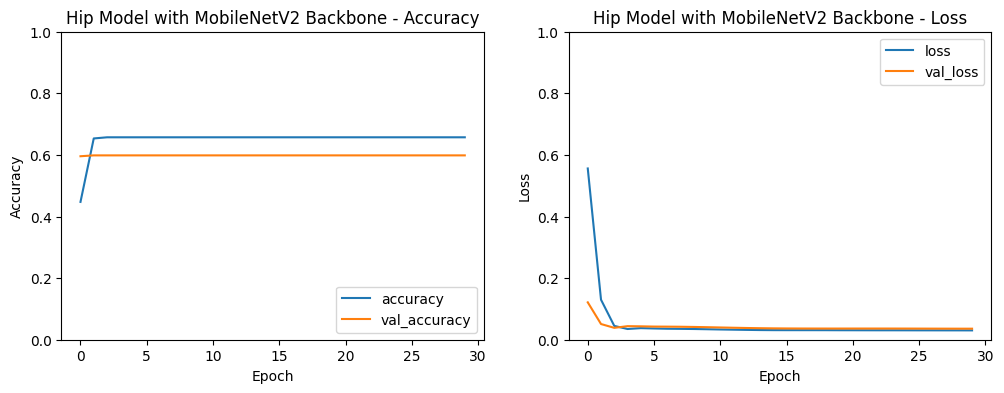

Epoch 1/30
3/3 [==============================] - 55s 12s/step - loss: 2.1259 - accuracy: 0.0015 - val_loss: 1.1552 - val_accuracy: 0.0212
Epoch 2/30
3/3 [==============================] - 32s 12s/step - loss: 0.7309 - accuracy: 0.3161 - val_loss: 0.2501 - val_accuracy: 0.7033
Epoch 3/30
3/3 [==============================] - 33s 12s/step - loss: 0.1928 - accuracy: 0.6692 - val_loss: 0.0409 - val_accuracy: 0.7037
Epoch 4/30
3/3 [==============================] - 35s 11s/step - loss: 0.2306 - accuracy: 0.6702 - val_loss: 0.0373 - val_accuracy: 0.7037
Epoch 5/30
3/3 [==============================] - 32s 12s/step - loss: 0.1940 - accuracy: 0.6702 - val_loss: 0.0339 - val_accuracy: 0.7037
Epoch 6/30
3/3 [==============================] - 33s 12s/step - loss: 0.1712 - accuracy: 0.6702 - val_loss: 0.0449 - val_accuracy: 0.7037
Epoch 7/30
3/3 [==============================] - 33s 11s/step - loss: 0.1531 - accuracy: 0.6702 - val_loss: 0.0526 - val_accuracy: 0.7037
Epoch 8/30
3/3 [===========

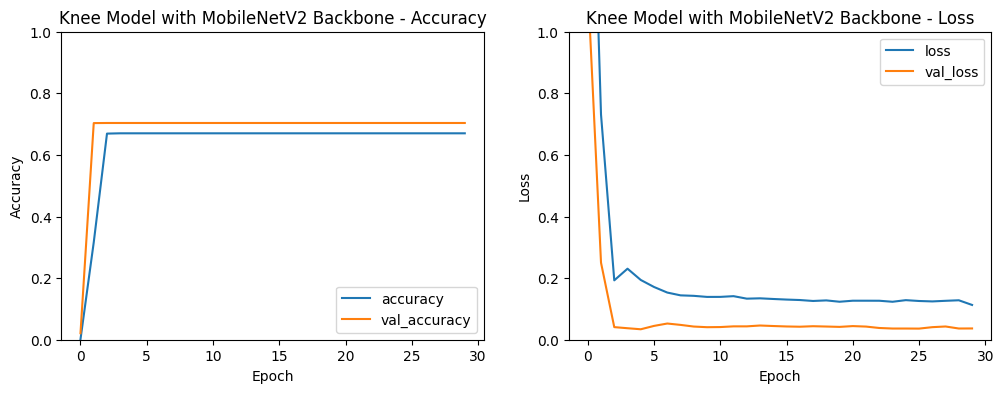

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, UpSampling2D, Lambda
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import nibabel as nib
from tensorflow.keras.applications import MobileNetV2

# Set the paths
hip_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Images"
hip_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Annotations"
knee_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Parameters
img_height, img_width = 224, 224
num_samples = 50  # Adjusted for 10,20,50,100,200,400,600

def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    img = apply_voi_lut(dicom.pixel_array, dicom)
    return img

def load_data(images_folder, annotations_folder, num_samples):
    images = []
    masks = []

    image_files = sorted(os.listdir(images_folder))[:num_samples]
    annotation_files = sorted(os.listdir(annotations_folder))[:num_samples]

    for img_file, ann_file in zip(image_files, annotation_files):
        img_path = os.path.join(images_folder, img_file)
        img = load_dicom_image(img_path)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # Match the 3-channel input shape expected by MobileNetV2

        ann_path = os.path.join(annotations_folder, ann_file)
        ann_img = nib.load(ann_path).get_fdata()
        ann_img = resize(ann_img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        if len(ann_img.shape) == 2:
            ann_img = np.expand_dims(ann_img, axis=-1)

        # Check if the shapes are consistent
        if img.shape != (img_height, img_width, 3) or ann_img.shape != (img_height, img_width, 1):
            print(f"Skipping {img_file} and {ann_file} due to inconsistent shapes: {img.shape}, {ann_img.shape}")
            continue  # Skip this pair of image and mask

        images.append(img)
        masks.append(ann_img)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks

def create_unet_mobilenet_model(input_size=(224, 224, 3)):
    # Load MobileNetV2 as the backbone
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')

    # Intermediate layers for skip connections
    block1 = base_model.get_layer('block_1_expand_relu').output
    block2 = base_model.get_layer('block_3_expand_relu').output
    block3 = base_model.get_layer('block_6_expand_relu').output
    block4 = base_model.get_layer('block_13_expand_relu').output
    block5 = base_model.get_layer('block_16_project').output

    # Decoder part of the U-Net
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5)
    x = concatenate([x, block4])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Resize the output to match the input size
    x = Lambda(lambda image: tf.image.resize(image, (img_height, img_width)))(x)

    return Model(inputs=base_model.input, outputs=x)

def train_and_evaluate_model(images, masks, model_name):
    # Normalize images
    images = images / 255.0
    masks = masks / 255.0

    # Split the data into training, validation, and test sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=42)
    train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=1/3, random_state=42)  # 0.25 * 0.75 = 0.1875

    # Get the model
    model = create_unet_mobilenet_model()

    # Compile it
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=30, batch_size=8)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    model.save(f"{model_name}.h5")
    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()


hip_images, hip_masks = load_data(hip_images_folder, hip_annotations_folder, num_samples)


train_and_evaluate_model(hip_images, hip_masks, "Hip Model with MobileNetV2 Backbone")


knee_images, knee_masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)


train_and_evaluate_model(knee_images, knee_masks, "Knee Model with MobileNetV2 Backbone")


Skipping 9025191.dcm and 9025191.nii.gz due to inconsistent shapes: (224, 224, 3), (224, 224, 2)
Epoch 1/30
3/3 [==============================] - 92s 23s/step - loss: 0.3224 - accuracy: 0.6572 - val_loss: 0.3767 - val_accuracy: 0.5985
Epoch 2/30
3/3 [==============================] - 58s 21s/step - loss: 0.0678 - accuracy: 0.6572 - val_loss: 0.3079 - val_accuracy: 0.5985
Epoch 3/30
3/3 [==============================] - 58s 21s/step - loss: 0.0615 - accuracy: 0.6572 - val_loss: 0.2518 - val_accuracy: 0.5985
Epoch 4/30
3/3 [==============================] - 57s 20s/step - loss: 0.0580 - accuracy: 0.6572 - val_loss: 0.2444 - val_accuracy: 0.5985
Epoch 5/30
3/3 [==============================] - 59s 22s/step - loss: 0.0367 - accuracy: 0.6572 - val_loss: 0.2361 - val_accuracy: 0.5985
Epoch 6/30
3/3 [==============================] - 63s 23s/step - loss: 0.0368 - accuracy: 0.6572 - val_loss: 0.2132 - val_accuracy: 0.5985
Epoch 7/30
3/3 [==============================] - 64s 23s/step - loss

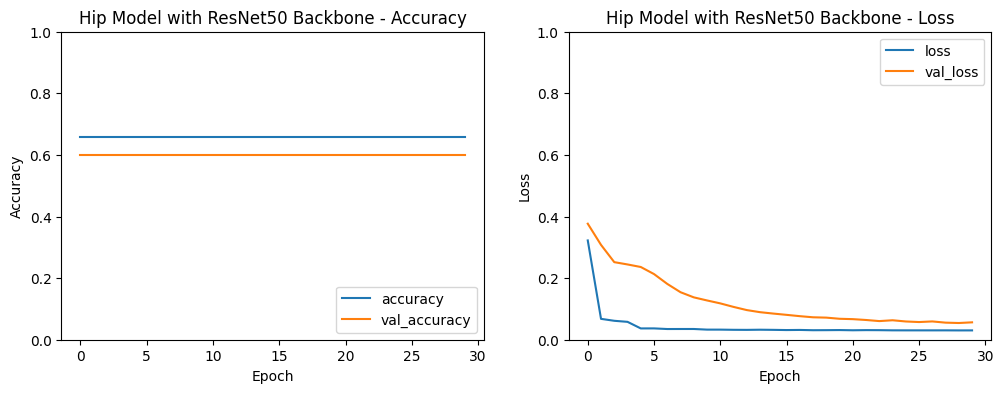

Epoch 1/30
3/3 [==============================] - 89s 21s/step - loss: 0.5463 - accuracy: 0.6387 - val_loss: 0.5508 - val_accuracy: 0.7037
Epoch 2/30
3/3 [==============================] - 60s 21s/step - loss: 0.2432 - accuracy: 0.6702 - val_loss: 0.5025 - val_accuracy: 0.7037
Epoch 3/30
3/3 [==============================] - 60s 22s/step - loss: 0.2505 - accuracy: 0.6702 - val_loss: 0.4663 - val_accuracy: 0.7037
Epoch 4/30
3/3 [==============================] - 60s 22s/step - loss: 0.1595 - accuracy: 0.6702 - val_loss: 0.4550 - val_accuracy: 0.7037
Epoch 5/30
3/3 [==============================] - 59s 21s/step - loss: 0.1336 - accuracy: 0.6702 - val_loss: 0.4281 - val_accuracy: 0.7037
Epoch 6/30
3/3 [==============================] - 56s 20s/step - loss: 0.1531 - accuracy: 0.6702 - val_loss: 0.3945 - val_accuracy: 0.7037
Epoch 7/30
3/3 [==============================] - 62s 23s/step - loss: 0.1281 - accuracy: 0.6702 - val_loss: 0.3527 - val_accuracy: 0.7037
Epoch 8/30
3/3 [===========

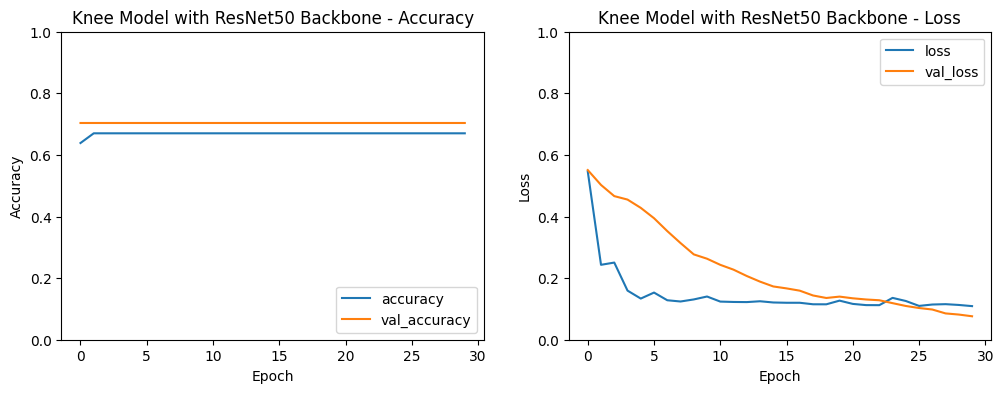

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, UpSampling2D, Lambda
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import nibabel as nib
from tensorflow.keras.applications import ResNet50

# Set the paths
hip_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Images"
hip_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Annotations"
knee_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Parameters
img_height, img_width = 224, 224
num_samples = 50  # Adjusted for 10,20,50,100,200,400,600

def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    img = apply_voi_lut(dicom.pixel_array, dicom)
    return img

def load_data(images_folder, annotations_folder, num_samples):
    images = []
    masks = []

    image_files = sorted(os.listdir(images_folder))[:num_samples]
    annotation_files = sorted(os.listdir(annotations_folder))[:num_samples]

    for img_file, ann_file in zip(image_files, annotation_files):
        img_path = os.path.join(images_folder, img_file)
        img = load_dicom_image(img_path)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # Match the 3-channel input shape

        ann_path = os.path.join(annotations_folder, ann_file)
        ann_img = nib.load(ann_path).get_fdata()
        ann_img = resize(ann_img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        if len(ann_img.shape) == 2:
            ann_img = np.expand_dims(ann_img, axis=-1)

        # Check if the shapes are consistent
        if img.shape != (img_height, img_width, 3) or ann_img.shape != (img_height, img_width, 1):
            print(f"Skipping {img_file} and {ann_file} due to inconsistent shapes: {img.shape}, {ann_img.shape}")
            continue  # Skip this pair of image and mask

        images.append(img)
        masks.append(ann_img)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks

def create_unet_resnet_model(input_size=(224, 224, 3)):
    # Load ResNet50 as the backbone
    base_model = ResNet50(input_shape=input_size, include_top=False, weights=None)

    # Decoder part of the U-Net
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(base_model.output)
    x = concatenate([x, base_model.get_layer('conv4_block6_out').output])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv3_block4_out').output])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv2_block3_out').output])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, base_model.get_layer('conv1_relu').output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Resize the output to match the input size
    x = Lambda(lambda image: tf.image.resize(image, (img_height, img_width)))(x)

    return Model(inputs=base_model.input, outputs=x)

def train_and_evaluate_model(images, masks, model_name):
    # Normalize images
    images = images / 255.0
    masks = masks / 255.0

    # Split the data into training, validation, and test sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=42)
    train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=1/3, random_state=42)  # 0.25 * 0.75 = 0.1875

    # Get the model
    model = create_unet_resnet_model()

    # Compile it
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=30, batch_size=8)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    model.save(f"{model_name}.h5")
    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()


hip_images, hip_masks = load_data(hip_images_folder, hip_annotations_folder, num_samples)


train_and_evaluate_model(hip_images, hip_masks, "Hip Model with ResNet50 Backbone")


knee_images, knee_masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)


train_and_evaluate_model(knee_images, knee_masks, "Knee Model with ResNet50 Backbone")


Skipping 9025191.dcm and 9025191.nii.gz due to inconsistent shapes: (224, 224, 3), (224, 224, 2)
Epoch 1/30
3/3 [==============================] - 149s 43s/step - loss: 0.6617 - accuracy: 0.5122 - val_loss: 0.5690 - val_accuracy: 0.5985
Epoch 2/30
3/3 [==============================] - 118s 43s/step - loss: 0.4960 - accuracy: 0.6570 - val_loss: 0.4074 - val_accuracy: 0.5985
Epoch 3/30
3/3 [==============================] - 113s 41s/step - loss: 0.1411 - accuracy: 0.6572 - val_loss: 0.2755 - val_accuracy: 0.5985
Epoch 4/30
3/3 [==============================] - 115s 42s/step - loss: 0.0722 - accuracy: 0.6572 - val_loss: 0.0921 - val_accuracy: 0.5985
Epoch 5/30
3/3 [==============================] - 117s 43s/step - loss: 0.0730 - accuracy: 0.6572 - val_loss: 0.0790 - val_accuracy: 0.5985
Epoch 6/30
3/3 [==============================] - 117s 42s/step - loss: 0.0728 - accuracy: 0.6572 - val_loss: 0.0870 - val_accuracy: 0.5985
Epoch 7/30
3/3 [==============================] - 112s 41s/step

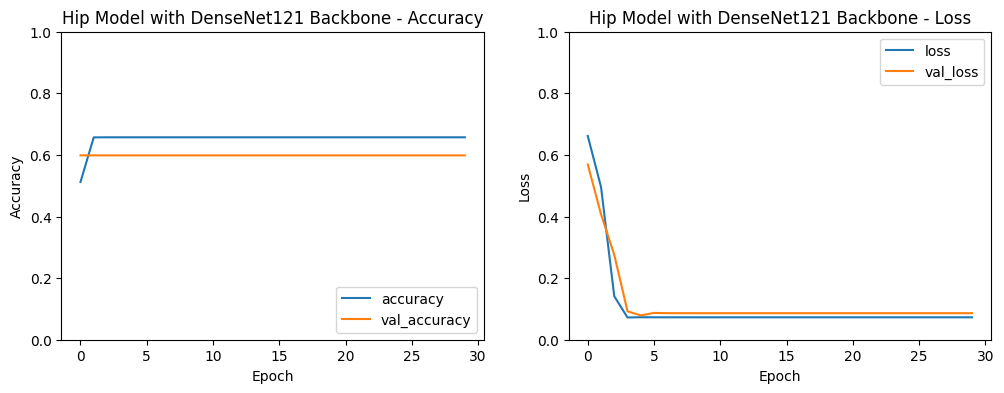

Epoch 1/30
3/3 [==============================] - 156s 43s/step - loss: 0.6928 - accuracy: 0.3469 - val_loss: 0.6533 - val_accuracy: 0.6966
Epoch 2/30
3/3 [==============================] - 117s 43s/step - loss: 0.6104 - accuracy: 0.6646 - val_loss: 0.5793 - val_accuracy: 0.7034
Epoch 3/30
3/3 [==============================] - 118s 42s/step - loss: 0.4632 - accuracy: 0.6699 - val_loss: 0.4988 - val_accuracy: 0.7037
Epoch 4/30
3/3 [==============================] - 115s 41s/step - loss: 0.2228 - accuracy: 0.6702 - val_loss: 0.4343 - val_accuracy: 0.7037
Epoch 5/30
3/3 [==============================] - 114s 41s/step - loss: 0.1734 - accuracy: 0.6702 - val_loss: 0.4408 - val_accuracy: 0.7037
Epoch 6/30
3/3 [==============================] - 122s 44s/step - loss: 0.1354 - accuracy: 0.6702 - val_loss: 0.4158 - val_accuracy: 0.7037
Epoch 7/30
3/3 [==============================] - 118s 42s/step - loss: 0.1279 - accuracy: 0.6702 - val_loss: 0.3649 - val_accuracy: 0.7037
Epoch 8/30
3/3 [====

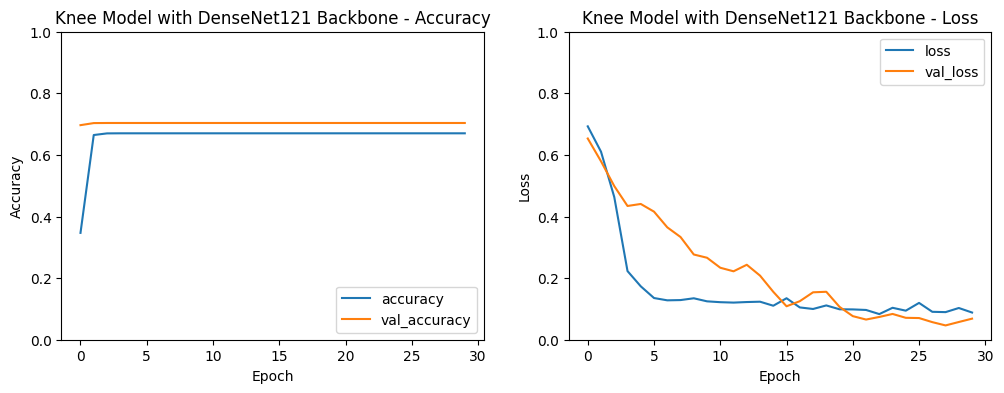

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, Conv2DTranspose, UpSampling2D, Lambda
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import nibabel as nib
from tensorflow.keras.applications import DenseNet121

# Set the paths
hip_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Images"
hip_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Hip/Annotations"
knee_images_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
knee_annotations_folder = "/content/drive/MyDrive/dataset/JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Parameters
img_height, img_width = 224, 224
num_samples = 50  # Adjusted for 10,20,50,100,200,400,600

def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    img = apply_voi_lut(dicom.pixel_array, dicom)
    return img

def load_data(images_folder, annotations_folder, num_samples):
    images = []
    masks = []

    image_files = sorted(os.listdir(images_folder))[:num_samples]
    annotation_files = sorted(os.listdir(annotations_folder))[:num_samples]

    for img_file, ann_file in zip(image_files, annotation_files):
        img_path = os.path.join(images_folder, img_file)
        img = load_dicom_image(img_path)
        img = resize(img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # Match the 3-channel input shape

        ann_path = os.path.join(annotations_folder, ann_file)
        ann_img = nib.load(ann_path).get_fdata()
        ann_img = resize(ann_img, (img_height, img_width), preserve_range=True, anti_aliasing=True)
        if len(ann_img.shape) == 2:
            ann_img = np.expand_dims(ann_img, axis=-1)

        # Check if the shapes are consistent
        if img.shape != (img_height, img_width, 3) or ann_img.shape != (img_height, img_width, 1):
            print(f"Skipping {img_file} and {ann_file} due to inconsistent shapes: {img.shape}, {ann_img.shape}")
            continue  # Skip this pair of image and mask

        images.append(img)
        masks.append(ann_img)

    # Convert lists to numpy arrays
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)

    return images, masks

def create_unet_densenet_model(input_size=(224, 224, 3)):
    # Load DenseNet121 as the backbone
    base_model = DenseNet121(input_shape=input_size, include_top=False, weights=None)

    # Intermediate layers for skip connections
    block4 = base_model.get_layer('conv4_block24_concat').output
    block3 = base_model.get_layer('conv3_block12_concat').output
    block2 = base_model.get_layer('conv2_block6_concat').output
    block1 = base_model.get_layer('conv1/relu').output

    # Decoder part of the U-Net
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block4)
    x = concatenate([x, block3])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block2])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block1])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Resize the output to match the input size
    x = Lambda(lambda image: tf.image.resize(image, (img_height, img_width)))(x)

    return Model(inputs=base_model.input, outputs=x)

def train_and_evaluate_model(images, masks, model_name):
    # Normalize images
    images = images / 255.0
    masks = masks / 255.0

    # Split the data into training, validation, and test sets
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=42)
    train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=1/3, random_state=42)  # 0.25 * 0.75 = 0.1875

    # Get the model
    model = create_unet_densenet_model()

    # Compile it
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=30, batch_size=8)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    model.save(f"{model_name}.h5")
    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()


hip_images, hip_masks = load_data(hip_images_folder, hip_annotations_folder, num_samples)


train_and_evaluate_model(hip_images, hip_masks, "Hip Model with DenseNet121 Backbone")


knee_images, knee_masks = load_data(knee_images_folder, knee_annotations_folder, num_samples)


train_and_evaluate_model(knee_images, knee_masks, "Knee Model with DenseNet121 Backbone")
